<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/BiGRU/emo_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install -q keras-tuner
# !rm -r emotion
# !git clone --branch BiGRU https://github.com/ppkgtmm/emotion.git emotion

In [3]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import  Tokenizer
from emotion.models import utils, lstm
from kerastuner.tuners.bayesian import BayesianOptimization
from kerastuner import HyperParameters

In [4]:
num_words = 15000
max_len = 300
hp = HyperParameters()
hp.Choice('output_dim',[128, 256])
hp.Choice('optimizer', ['adam', 'amsgrad'])
hp.Choice('lstm_units', [16, 32, 64, 128])
hp.Fixed('max_len', max_len)
hp.Fixed('num_words', num_words)
seed = 1234

In [5]:
train, test = utils.read_and_split()
train.sample(5)

,text,target
10230,i do when i feel lethargic,sadness
6273,i sing i swim this feels like a pleasant passi...,joy
1401,i understand the logic of having a student con...,sadness
16925,i am feeling triumphant i bang my helmet hard ...,joy
13290,i didnt need that reminder plus her words made...,sadness


In [6]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [7]:
sequence_train = utils.get_sequences(tokenizer, train['text'], max_len)
sequence_test = utils.get_sequences(tokenizer, test['text'], max_len)

In [8]:
target_train = utils.OH_fit_transform(train['target'])
target_test = utils.OH_transform(test['target'])

In [9]:
tuner = BayesianOptimization( lstm.build_lstm,
                              'val_accuracy',
                              16,
                              executions_per_trial=2,
                              hyperparameters=hp, 
                              seed=seed,
                              num_initial_points=5,
                              project_name='/content/drive/MyDrive/__ed__/lstm_B32',
                            )

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/__ed__/lstm_B32/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          1920000   
_________________________________________________________________
lstm (LSTM)                  (None, 16)                9280      
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
Total params: 1,929,382
Trainable params: 1,929,382
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/__ed__/lstm_B32/tuner0.json


In [ ]:
history = tuner.search(
    sequence_train, target_train,
    validation_split=0.1,
    epochs=3
)

Trial 16 Complete [00h 02m 56s]
val_accuracy: 0.9244117438793182

Best val_accuracy So Far: 0.9288235306739807
Total elapsed time: 00h 42m 57s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
output_dim (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'amsgrad'], 'ordered': False}
lstm_units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
max_len (Fixed)
{'conditions': [], 'value': 300}
num_words (Fixed)
{'conditions': [], 'value': 15000}


In [ ]:
tuner.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/__ed__/lstm_B32
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
lstm_units: 128
max_len: 300
num_words: 15000
Score: 0.9288235306739807
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
lstm_units: 128
max_len: 300
num_words: 15000
Score: 0.9288235306739807
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
lstm_units: 128
max_len: 300
num_words: 15000
Score: 0.9276470839977264


In [10]:
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 256)          3840000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 4,037,894
Trainable params: 4,037,894
Non-trainable params: 0
_________________________________________________________________


94/94 [==============================] - 1s 9ms/step
Accuracy:	91.6%


              precision    recall  f1-score   support

       anger       0.90      0.94      0.92       406
        fear       0.91      0.85      0.88       356
         joy       0.95      0.91      0.93      1014
        love       0.82      0.85      0.83       246
     sadness       0.94      0.97      0.95       870
    surprise       0.73      0.83      0.78       108

    accuracy                           0.92      3000
   macro avg       0.88      0.89      0.88      3000
weighted avg       0.92      0.92      0.92      3000



<Figure size 432x288 with 0 Axes>

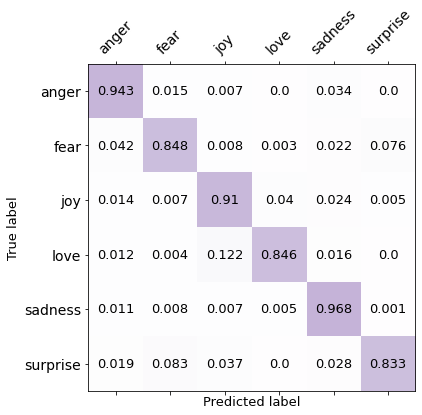

In [12]:
utils.model_evaluate(best_model, sequence_test, target_test, 32)

In [ ]:
# best_model.save('best_lstm.h5')
# utils.dump(tokenizer,'/content/drive/MyDrive/__ed__/lstm_B32/tokenizer.pickle')

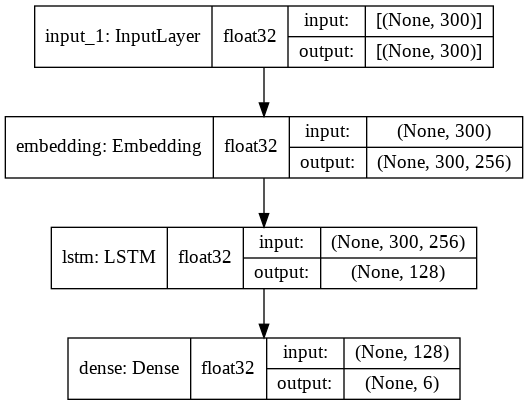

In [ ]:
from keras.utils import plot_model
plot_model(
    best_model,
    to_file='/content/drive/MyDrive/__ed__/lstm_B32/plot.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True
    )